# Task 3: System integration and research
## Craig Atkinson a1669436

In [ ]:
class Recommendations:
    """
    Usage: Product Recommendation System with a Terminal Text Interface
    Input: Text Interface will ask for UserID and "with or without frequent patterns"
    Output: List of product recommendations the provided User
    """
    
    def __init__(self,data):
        self.data=data
    
    def pattern_mining(self):
        "Version 1 of the task1 function"
        from mlxtend.preprocessing import TransactionEncoder
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.frequent_patterns import fpmax, fpgrowth

        #group columns user and set as list
        grouped = self.data.groupby(['User_id', 'Date'])['itemDescription'].apply(list).reset_index()
        
        #only the itemDescription column as product transactions list
        transactions = grouped['itemDescription'].tolist()
        
        #encode transations list as one-Hot vector
        te = TransactionEncoder()
        te_array = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_array, columns=te.columns_)

        #use apriori algor to generation association rules
        frequent_itemsets_apriori = apriori(df_encoded, min_support=0.1, use_colnames=True)
        frequent_itemsets_apriori=frequent_itemsets_apriori.sort_values('support')
        #create association Rules
        rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.5)
        rules_apriori.head()
        return rules_apriori

    def collaborative_filtering(self,user_id, use_patterns):
        "Version 1 of the task2 function"
        from scipy.sparse import csr_matrix
        from implicit.als import AlternatingLeastSquares
        from implicit.nearest_neighbours import bm25_weight

        #create user-item matrix per day
        df_user_items = self.data.groupby(['User_id', 'itemDescription']).agg({'Date':['count']}).reset_index()
        df_user_items.columns = ['User_id', 'itemDescription', 'Quantity']
        user_items_matrix = df_user_items.pivot(index="User_id", columns="itemDescription", values="Quantity")
        user_items_matrix.fillna(0, inplace=True)

        #create sparse matrix from user-item matrix and apply BM25 weighing
        sparse_matrix = csr_matrix(user_items_matrix.values)
        weighted_matrix = bm25_weight(sparse_matrix.T).T

        #train the model, first use default parameters (should do parameter tuning in later versions)
        model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, random_state=888)
        model.fit(weighted_matrix,show_progress=0)
        
        user_mapping = list(user_items_matrix.index)

        #map the provided user id
        user_index = user_mapping.index(user_id)
        
        recommended = model.recommend(user_index, sparse_matrix[user_index], N=5)
        item_mapping = list(user_items_matrix.columns)
        recommended_items = [item_mapping[item_id] for item_id in recommended[0]]

        
        if use_patterns == 'with':
            #placeholder, not yet fully integrated
            frequencyList= self.pattern_mining()
            print(frequencyList)
            return ['item1','item2','item3','item4','item5']
        else:
            return recommended_items

    def text_program(self):
        "Runs the Text Interface, which calls the other tasks"
        print("Product Recommendation System")
        
        while True:
            user_id_input = input("Enter user ID or enter 'q' to quit: ")
            if user_id_input.lower() == 'q':
                break
            #validate input is numerical    
            try:
                user_id = int(user_id_input)
            except:
                print("Please Only Enter a Numerical User ID")
                continue
                
            method_input = input("With or Without frequent patterns?: (enter with or without)")
            use_patterns = method_input.lower()
            
            if use_patterns in ['with', 'without']:
                recommendations = self.collaborative_filtering(user_id, use_patterns)
                for item in recommendations:
                    print(item)
            else:
                print('Please Only Enter with or without')

if __name__ == "__main__":
    import pandas as pd
    import warnings 
    warnings.filterwarnings('ignore')
    
    data = pd.read_csv('Groceries data train.csv')
    data = data.dropna()
    recommend = Recommendations(data)
    recommend.text_program()

Product Recommendation System


Enter user ID or enter 'q' to quit:  1004
With or Without frequent patterns?: (enter with or without) with


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
item1
item2
item3
item4
item5


## Exploratory Data Analysis 
Plots and statsistics of training dataset, for the group report

User Average Number of Purchases:
 count    3493.000000
mean        5.548812
std         3.238378
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        24.000000
Name: count, dtype: float64


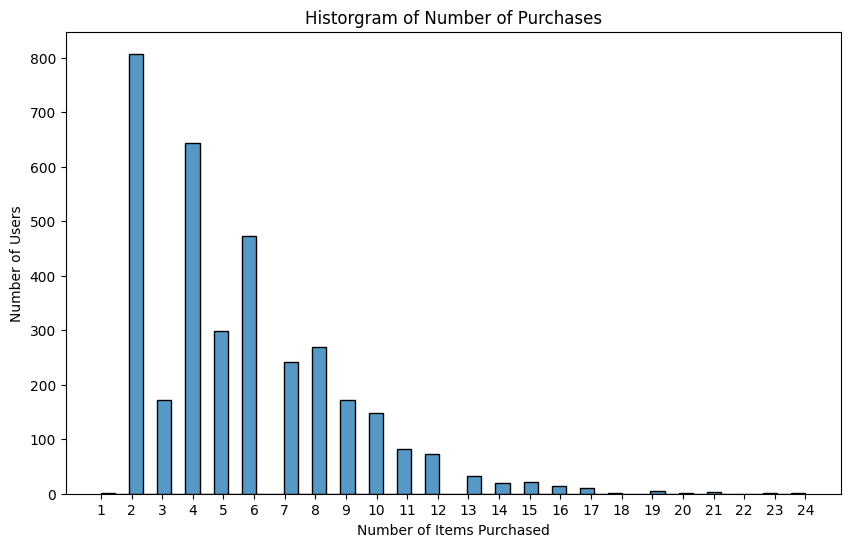

In [2]:
#EDA
import matplotlib.pyplot as plt
import seaborn as sns

#average user statisics
user_counts = data['User_id'].value_counts()
print("User Average Number of Purchases:\n", user_counts.describe())

#historgram of Number of Purchases
plt.figure(figsize=(10, 6))
sns.histplot(user_counts, bins=50)
plt.title('Historgram of Number of Purchases')
plt.xlabel('Number of Items Purchased')
plt.ylabel('Number of Users')
plt.xticks(range(1,25))
plt.show()

Top 20 most popular items:
 itemDescription
whole milk               1135
other vegetables          916
rolls/buns                878
soda                      816
yogurt                    678
bottled water             525
root vegetables           512
shopping bags             455
pastry                    421
tropical fruit            410
whipped/sour cream        376
newspapers                353
bottled beer              344
brown bread               341
domestic eggs             336
pip fruit                 315
fruit/vegetable juice     313
margarine                 302
canned beer               291
citrus fruit              291
Name: count, dtype: int64
Bottom 20 least popular items:
 itemDescription
cooking chocolate         9
flower soil/fertilizer    8
frozen fruits             7
fish                      7
cookware                  7
cream                     7
decalcifier               5
liqueur                   5
organic products          5
toilet cleaner            5
ha

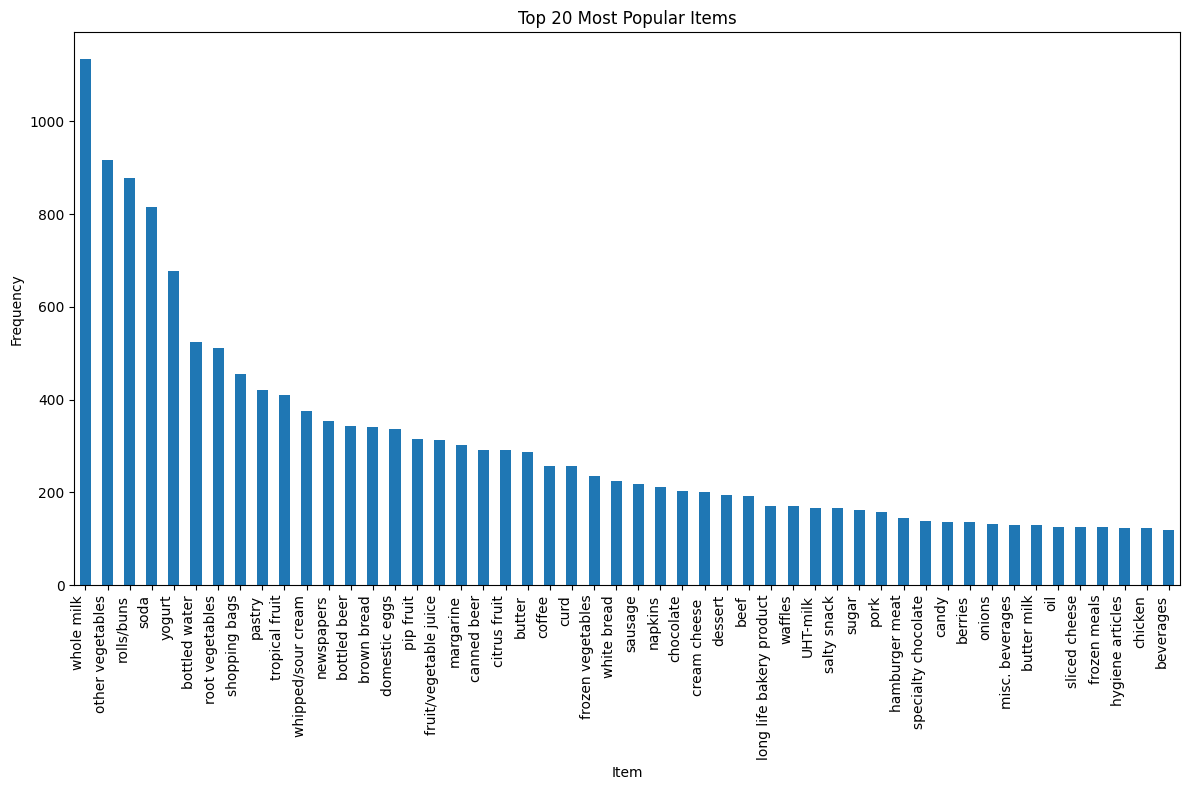

In [3]:
item_counts = data['itemDescription'].value_counts()

print("Top 20 most popular items:\n", item_counts.head(20))
print("Bottom 20 least popular items:\n", item_counts.tail(20))

plt.figure(figsize=(12, 8))
item_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Popular Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

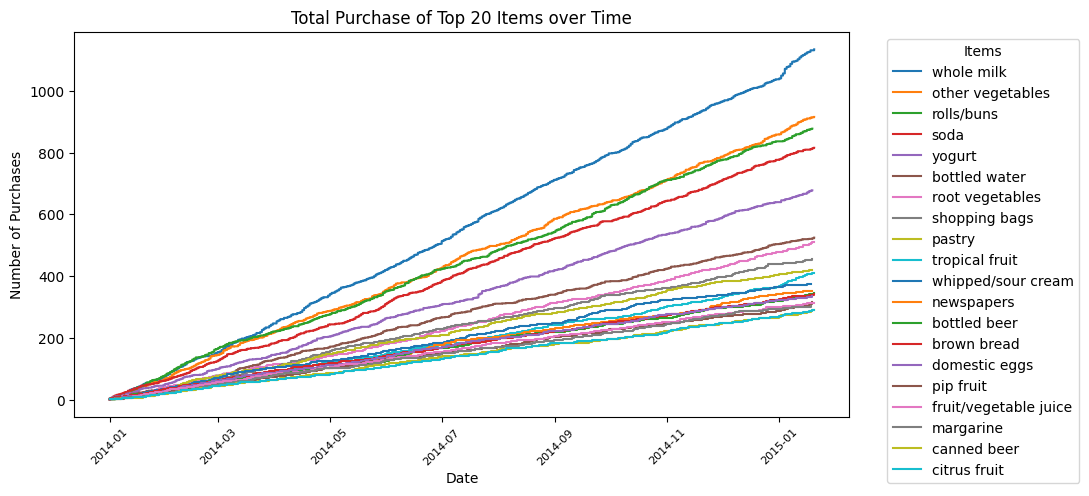

In [4]:
#convert creation time column to pandas datetime type
data=data.dropna()
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data= data.sort_values('Date')
plt.figure(figsize=(10, 5))

#for each cluster, create a time series line
for item in item_counts.head(20).keys():
    item_data = data[data['itemDescription'] == item]
    
    dates = item_data['Date']
    counts = range(1, len(item_data) + 1)
    #plot each post in the cluster as a timestep
    plt.step(dates, counts, where='post', label=f'{item}')

plt.title('Total Purchase of Top 20 Items over Time')
plt.xlabel('Date')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('Number of Purchases')
plt.legend(title='Items', loc='upper left', bbox_to_anchor=(1.04, 1))

plt.show()



itemDescription  Instant food products  UHT-milk  abrasive cleaner  \
YearMonth                                                            
2014-01                              5         9                 1   
2014-02                              7         9                 0   
2014-03                              4        10                 2   
2014-04                              2        15                 0   
2014-05                              3        20                 1   

itemDescription  artif. sweetener  baby cosmetics  bags  baking powder  \
YearMonth                                                                
2014-01                         0               0     0              5   
2014-02                         0               0     0              2   
2014-03                         1               0     1              5   
2014-04                         2               0     0              7   
2014-05                         2               0     0          

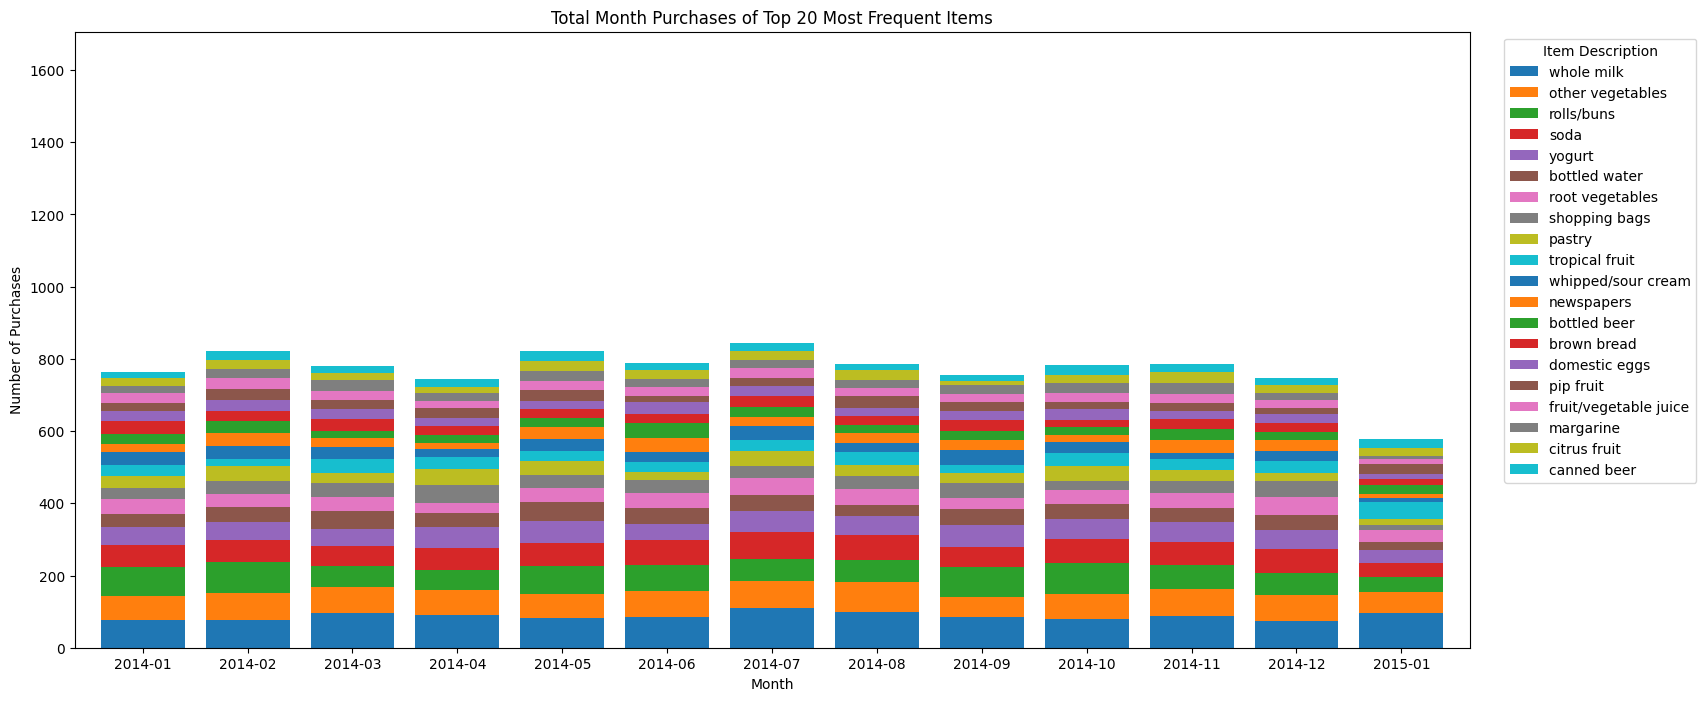

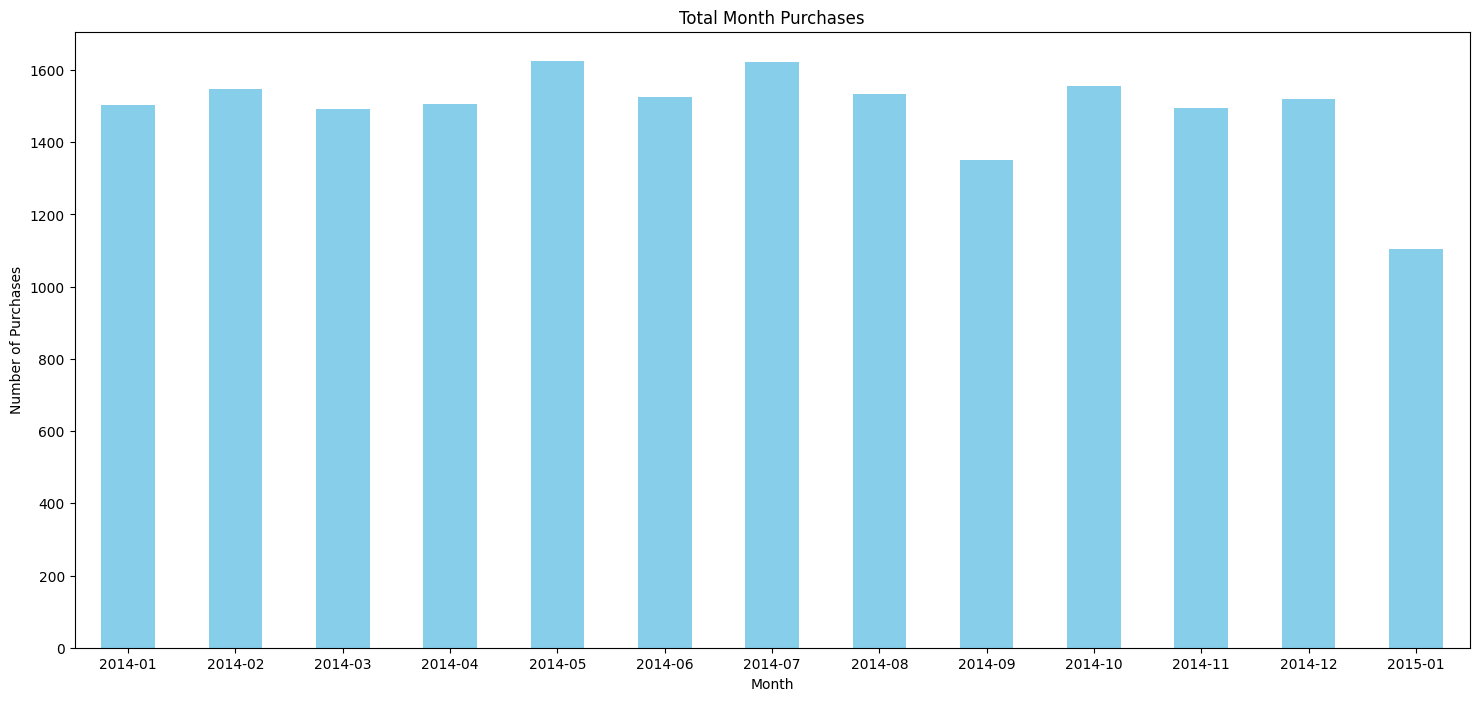

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#year-month for monthly calculation '2014-01'
data['YearMonth'] = data['Date'].dt.to_period('M')

#total counts per month
monthly_counts = data.groupby(['YearMonth']).size()

#group by year-month and item name
monthly_counts_item = data.groupby(['YearMonth', 'itemDescription']).size()
pivot_data_item = monthly_counts_item.unstack(fill_value=0)
print(pivot_data_item.head())

item_totals = data['itemDescription'].value_counts()
top_n_items = item_totals.head(20).index.tolist()
pivot_data_to_plot = pivot_data_item[top_n_items]

fig, ax = plt.subplots(figsize=(18, 8))
monthly_counts.plot(kind='line', ax=ax, color='black', marker='o')
pivot_data_to_plot.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title('Total Month Purchases of Top 20 Most Frequent Items')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases')
ax.tick_params(axis='x', rotation=0)
legend = plt.legend(title='Item Description', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize=(18, 8))
monthly_counts.plot(kind='bar', ax=ax, color='skyblue') 
ax.set_title('Total Month Purchases')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases')
ax.tick_params(axis='x', rotation=0)
plt.show()

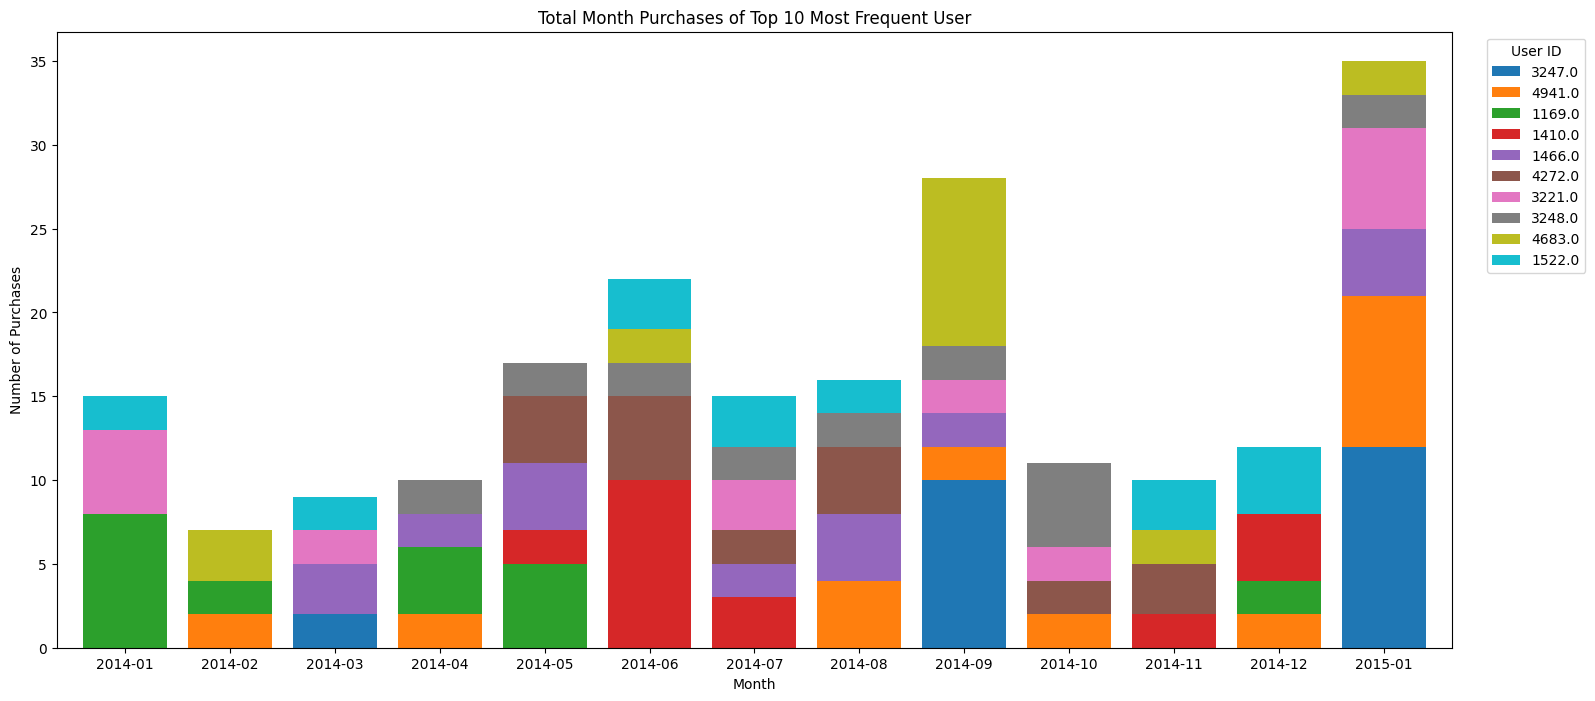

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#year-month for monthly calculation '2014-01'
data['YearMonth'] = data['Date'].dt.to_period('M')

#total counts per month
monthly_counts = data.groupby(['YearMonth']).size()

#group by year-month and item name
monthly_counts_item = data.groupby(['YearMonth', 'User_id']).size()
pivot_data_item = monthly_counts_item.unstack(fill_value=0)

item_totals = data['User_id'].value_counts()
top_n_items = item_totals.head(10).index.tolist()
pivot_data_to_plot = pivot_data_item[top_n_items]

fig, ax = plt.subplots(figsize=(18, 8))
pivot_data_to_plot.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title('Total Month Purchases of Top 10 Most Frequent User')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases')
ax.tick_params(axis='x', rotation=0)
legend = plt.legend(title='User ID', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


## Reflection

In version 1 of the program, the Recommendation System was created as a python program. The program is made up of a main routine and a object class called "Recommendations". The object "Recommendations" has three main functions, "pattern_mining", "collaborative_filtering", and "text_interface". In this version of the program, "pattern_mining", "colabrative_filtering" are placeholder functions for the work of the other group members (group task 1 and 2). The function "text_interface" is what the program user will interactive to get the results. It first prompts the user for to input a userID number and ask for the "with or without" input. The function will then called the "pattern_mining", "colabrative_filtering functions and then return the product recommendations. The program will then continue to loop until the user inputs the 'q' command to quit.

In version 2 of the program, an error was found if the user inputs a non-numerical input string when asked for userID, this was fixed by validating the input and outputing a try again message to the user, which avoids the program crashing with an error message. Additionally, some EDA statsistics and graphs were generated in the jupyter notebook, which will help the group better understand the dataset and be used in the group report.

In version 3 of the program, the first versions of task 1 and task 2 were added to the Reccommendations functions "pattern_mining" and "collaborative_filtering". The "collaborative_filtering" method is working using the "implicit" python module, I added the ignore warnings and show_progress=false so that the user does not see unessessary warnings while using the program. The output of the "collaborative_filtering" function is providing recommended items based on similar users as expected. However, the 'with frequent patterns' option has not yet been implimented due to issues with the "pattern_mining" function. THe current implimentation of the "pattern_mining" function is not providing the patterns and is returning an empty DataFrame.

